In [1]:
import pandas as pd
import numpy as np
import cvxpy as cp
from tqdm import trange
import matplotlib.pyplot as plt

from cvx.covariance.ewma import iterated_ewma

In [2]:
returns = pd.read_csv('../../data/ff5_no_rf.csv', index_col=0, parse_dates=True)

# Risk-free rate
FF = pd.read_csv('../../data/ff5.csv', index_col=0, parse_dates=True)
rf_rate = pd.DataFrame(FF.loc[:,"RF"])
rf_rate.index = pd.to_datetime(rf_rate.index, format='%Y%m%d')

In [3]:
# IEWMA  
iewma = list(iterated_ewma(returns, vola_halflife=21, cov_halflife=63, min_periods_vola=10, min_periods_cov=10))
iewma = {iterate.time: iterate.covariance for iterate in iewma}

# Prescient
prescient = {}
for t in returns.index:
    # get sample covariance matrix for corresponding quarter
    quarter = (t.month-1)//3 + 1
    cov = np.cov(returns.loc[(returns.index.year == t.year) & (returns.index.quarter == quarter)].values, rowvar=False)
    mean = np.mean(returns.loc[(returns.index.year == t.year) & (returns.index.quarter == quarter)].values, axis=0)
    prescient[t] = pd.DataFrame(cov+np.outer(mean, mean), index=returns.columns, columns=returns.columns)

In [4]:
def smooth_covariance(Sigmas, lamda=0.1, KL=False, smoothly_varying=True):
    n = returns.shape[1]
    if KL:
        L_smoothed = cp.Variable((n, n), PSD=True)
        Theta_old = cp.Parameter((n, n), PSD=True)
        Theta_unsmoothed = cp.Parameter((n, n), PSD=True)
        Sigma_unsmoothed = cp.Parameter((n, n), PSD=True)


    Sigma_smoothed = cp.Variable((n, n), PSD=True)
    Sigma_old = cp.Parameter((n, n), PSD=True)
    Sigma_unsmoothed = cp.Parameter((n, n), PSD=True)

    # Objective function
    if KL:
        KL = cp.trace((L_smoothed@L_smoothed.T)@Sigma_unsmoothed) - 2*cp.sum(cp.log(cp.diag(L_smoothed)))
        if smoothly_varying:
            obj = cp.Minimize(KL + lamda*cp.norm(L_smoothed@L_smoothed.T - Theta_old, "fro")**2)
        else:
            obj = cp.Minimize(KL + lamda*cp.norm(L_smoothed@L_smoothed.T - Theta_old, "fro"))
    else:
        if smoothly_varying:
            obj = cp.Minimize(cp.norm(Sigma_unsmoothed - Sigma_smoothed, "fro")**2 + lamda*cp.norm(Sigma_smoothed - Sigma_old, "fro")**2)
        else:
            obj = cp.Minimize(cp.norm(Sigma_unsmoothed - Sigma_smoothed, "fro")**2 + lamda*cp.norm(Sigma_smoothed - Sigma_old, "fro"))


    Sigmas_smoothed = np.zeros_like(Sigmas)
    Sigmas_smoothed[0] = Sigmas[0]

    for i in trange(1, len(Sigmas)):
        if not KL:
            Sigma_old.value = Sigmas_smoothed[i-1]
            Sigma_unsmoothed.value = Sigmas[i]
            problem = cp.Problem(obj)
            problem.solve()
            Sigmas_smoothed[i] = Sigma_smoothed.value
        else:
            Theta_old.value = np.linalg.inv(Sigmas_smoothed[i-1])
            Theta_unsmoothed.value = np.linalg.inv(Sigmas[i])
            Sigma_unsmoothed.value = Sigmas[i]
            problem = cp.Problem(obj)
            problem.solve()
            L = L_smoothed.value
            Sigmas_smoothed[i] = np.linalg.inv(L@L.T)

    return Sigmas_smoothed


# Smoothly varying

In [5]:
Sigmas_unsmoothed = np.array([*iewma.values()])*10000

In [6]:
Sigmas_smoothed = smooth_covariance(Sigmas_unsmoothed, KL=False, lamda=1000, smoothly_varying=True)

100%|██████████| 14960/14960 [07:08<00:00, 34.94it/s]


In [81]:
Sigmas_piece_const = smooth_covariance(Sigmas_unsmoothed, lamda=0.1, KL=False, smoothly_varying=False)

100%|██████████| 14960/14960 [07:34<00:00, 32.95it/s]


In [23]:
# frob_diffs_smooth = []
# for i in range(1,len(Sigmas_unsmoothed)):
#     frob_diffs_smooth.append(np.linalg.norm(Sigmas_smoothed[i]-Sigmas_smoothed[i-1], ord='fro'))
# frob_diffs_smooth = pd.Series(frob_diffs_smooth, index=returns.index[-len(frob_diffs_smooth):])


frob_diffs_piece_const = []
for i in range(1, len(Sigmas_unsmoothed)):
    frob_diffs_piece_const.append(np.linalg.norm(Sigmas_piece_const[i]-Sigmas_piece_const[i-1], ord='fro'))
frob_diffs_piece_const = pd.Series(frob_diffs_piece_const, index=returns.index[-len(frob_diffs_piece_const):])

frob_diffs_orig = []
for i in range(1, len(Sigmas_unsmoothed)):
    frob_diffs_orig.append(np.linalg.norm(Sigmas_unsmoothed[i]-Sigmas_unsmoothed[i-1], ord='fro'))
frob_diffs_orig = pd.Series(frob_diffs_orig, index=returns.index[-len(frob_diffs_orig):])

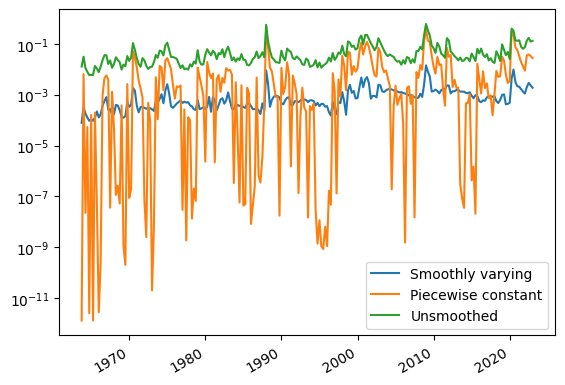

In [10]:
plt.plot(frob_diffs_smooth.resample("Q").mean(), label="Smoothly varying")
plt.plot(frob_diffs_piece_const.resample("Q").mean(), label = "Piecewise constant")
plt.plot(frob_diffs_orig.resample("Q").mean(), label = "Unsmoothed")
plt.legend()
plt.yscale('log')

plt.gcf().autofmt_xdate();

# Log likelihoods

In [12]:
from experiments.experiment_utils import log_likelihood

In [13]:
times = list(iewma.keys())
original = {times[t]: Sigmas_unsmoothed[t]/10000 for t in range(len(times))}
smoothed = {times[t]: Sigmas_smoothed[t]/10000 for t in range(len(times))}
piece_const = {times[t]: Sigmas_piece_const[t]/10000 for t in range(len(times))}

prescient = {time: prescient[time] for time in times}

names = ["Original", "Smoothed", "Piecewise constant", "Prescient"]
predictors = [original, smoothed, piece_const, prescient]

In [14]:
log_likelihoods = {}

for i, predictor in enumerate(predictors):
    print("Computing " + names[i] + " log-likelihood...")
    returns_temp = returns.loc[pd.Series(predictor).index].values[1:]
    times = pd.Series(predictor).index[1:]
    try:
        Sigmas_temp = np.stack([predictor[t].values for t in predictor.keys()])[:-1]
    except:
        Sigmas_temp = np.stack([predictor[t] for t in predictor.keys()])[:-1]


    log_likelihoods[names[i]] = pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times)

regrets = {}
for name in log_likelihoods:
    regrets[name] =  log_likelihoods["Prescient"] - log_likelihoods[name]

Computing Original log-likelihood...
Computing Smoothed log-likelihood...
Computing Piecewise constant log-likelihood...
Computing Prescient log-likelihood...


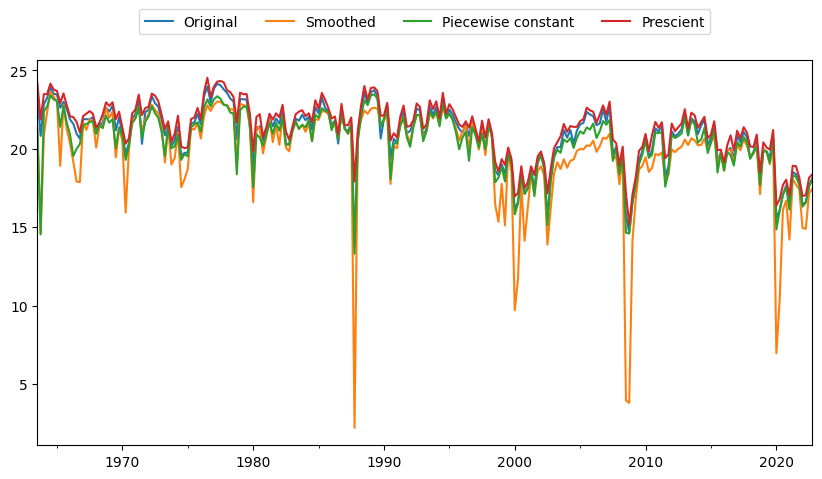

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'PRESCIENT':
        log_likelihoods[name].resample("Q").mean().plot(label=name, c="k")
    else:
        log_likelihoods[name].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=names, scatterpoints=1, markerscale=5);
# plt.ylim(13,25);

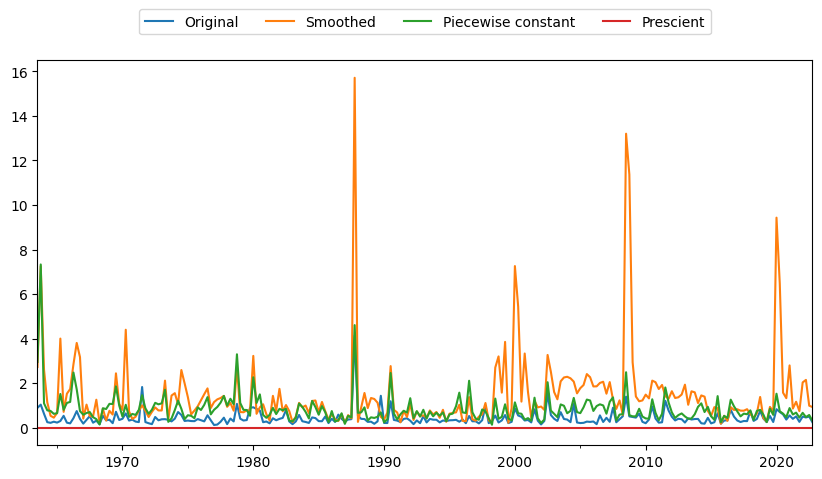

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'PRESCIENT':
        pass
    else:
        regrets[name].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=names, scatterpoints=1, markerscale=5);
# plt.ylim(-0.5,10);


# New (piecewise constant) smoothing experiments

In [9]:
# IEWMA  
iewma = list(iterated_ewma(returns, vola_halflife=21, cov_halflife=63, min_periods_vola=10, min_periods_cov=10))
iewma = {iterate.time: iterate.covariance for iterate in iewma}

# Prescient
prescient = {}
for t in returns.index:
    # get sample covariance matrix for corresponding quarter
    quarter = (t.month-1)//3 + 1
    cov = np.cov(returns.loc[(returns.index.year == t.year) & (returns.index.quarter == quarter)].values, rowvar=False)
    mean = np.mean(returns.loc[(returns.index.year == t.year) & (returns.index.quarter == quarter)].values, axis=0)
    prescient[t] = pd.DataFrame(cov+np.outer(mean, mean), index=returns.columns, columns=returns.columns)

In [10]:
n = returns.shape[1]

def get_next(Sigma_unsmooth, Sigma_prev, lamda):
    theta = cp.Variable()
    Xt = cp.Parameter((n,n), PSD=True)
    Y_old = cp.Parameter((n,n), PSD=True)

    Yt = theta*Xt + (1-theta)*Y_old

    Xt.value = Sigma_unsmooth
    Y_old.value = Sigma_prev

    obj = 1/2*cp.norm(Yt-Xt, "fro")**2 + lamda*cp.norm(Yt-Y_old, "fro")

    prob = cp.Problem(cp.Minimize(obj))
    prob.solve()
    return Yt.value

In [15]:
def smooth_covariance2(Sigmas, lamda0=0.1, greedy=False):
    Sigmas_smoothed = np.zeros_like(Sigmas)
    Sigmas_smoothed[0] = Sigmas[0]

    updates = [1]
    for i in trange(1, len(Sigmas)):
        lamda = lamda0 #* np.linalg.norm(Sigmas[i], "fro")
        Sigma_prev = Sigmas_smoothed[i-1]
        Sigma_unsmooth = Sigmas[i]
        if np.linalg.norm(Sigma_prev-Sigma_unsmooth, "fro")<=lamda:
            Sigmas_smoothed[i] = Sigma_prev
            updates.append(0)

        else:
            if not greedy:
                Sigmas_smoothed[i] = get_next(Sigma_unsmooth, Sigma_prev, lamda)
                updates.append(1)
            else:
                Sigmas_smoothed[i] = Sigma_unsmooth

    return Sigmas_smoothed, updates

In [13]:
Sigmas_unsmoothed = np.array([*iewma.values()])*10000

In [16]:
Sigmas_piece_const2, updates2 = smooth_covariance2(Sigmas_unsmoothed, lamda0=1)

100%|██████████| 14960/14960 [00:27<00:00, 552.30it/s] 


In [63]:
Sigmas_001, updates001 = smooth_covariance2(Sigmas_unsmoothed, lamda0=0.01)
Sigmas_01, updates01 = smooth_covariance2(Sigmas_unsmoothed, lamda0=0.1)
Sigmas_1, updates1 = smooth_covariance2(Sigmas_unsmoothed, lamda0=1)
Sigmas_10, updates10 = smooth_covariance2(Sigmas_unsmoothed, lamda0=10)
Sigmas_100, updates100 = smooth_covariance2(Sigmas_unsmoothed, lamda0=100)

100%|██████████| 14960/14960 [00:00<00:00, 159910.87it/s]


In [64]:
frob_diffs001 = []
for i in range(1, len(Sigmas_001)):
    frob_diffs001.append(np.linalg.norm(Sigmas_001[i]-Sigmas_001[i-1], ord='fro'))
frob_diffs001 = pd.Series(frob_diffs001, index=returns.index[-len(frob_diffs001):])

frob_diffs01 = []
for i in range(1, len(Sigmas_01)):
    frob_diffs01.append(np.linalg.norm(Sigmas_01[i]-Sigmas_01[i-1], ord='fro'))
frob_diffs01 = pd.Series(frob_diffs01, index=returns.index[-len(frob_diffs01):])

frob_diffs1 = []
for i in range(1, len(Sigmas_1)):
    frob_diffs1.append(np.linalg.norm(Sigmas_1[i]-Sigmas_1[i-1], ord='fro'))
frob_diffs1 = pd.Series(frob_diffs1, index=returns.index[-len(frob_diffs1):])

frob_diffs10 = []
for i in range(1, len(Sigmas_10)):
    frob_diffs10.append(np.linalg.norm(Sigmas_10[i]-Sigmas_10[i-1], ord='fro'))
frob_diffs10 = pd.Series(frob_diffs10, index=returns.index[-len(frob_diffs10):])

frob_diffs100 = []
for i in range(1, len(Sigmas_100)):
    frob_diffs100.append(np.linalg.norm(Sigmas_100[i]-Sigmas_100[i-1], ord='fro'))
frob_diffs100 = pd.Series(frob_diffs100, index=returns.index[-len(frob_diffs100):])

frob_diffs_orig = []
for i in range(1, len(Sigmas_unsmoothed)):
    frob_diffs_orig.append(np.linalg.norm(Sigmas_unsmoothed[i]-Sigmas_unsmoothed[i-1], ord='fro'))
frob_diffs_orig = pd.Series(frob_diffs_orig, index=returns.index[-len(frob_diffs_orig):])

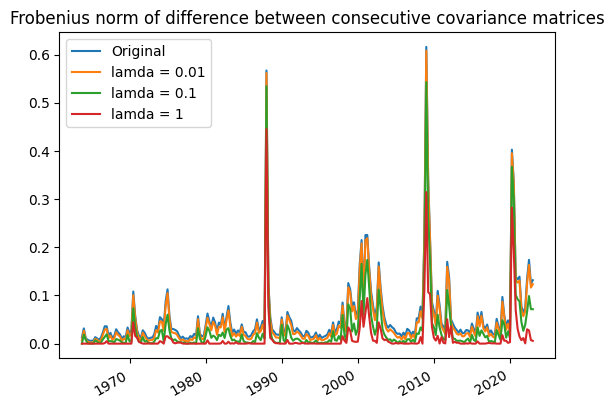

In [96]:
plt.plot(frob_diffs_orig.resample("Q").mean(), label = "Original")
plt.plot(frob_diffs001.resample("Q").mean(), label = "lamda = 0.01")
plt.plot(frob_diffs01.resample("Q").mean(), label = "lamda = 0.1")
plt.plot(frob_diffs1.resample("Q").mean(), label = "lamda = 1")
# plt.plot(frob_diffs10.resample("Q").mean(), label = "lamda = 10")
# plt.plot(frob_diffs100.resample("Q").mean(), label = "lamda = 100")
plt.title("Frobenius norm of difference between consecutive covariance matrices")
plt.legend()


# plt.yscale('log')

# plt.xlim(returns.index[8000], returns.index[10000])
plt.gcf().autofmt_xdate();

# Log likelihoods

In [60]:
from experiments.experiment_utils import log_likelihood

In [92]:
times = list(iewma.keys())
original = {times[t]: Sigmas_unsmoothed[t]/10000 for t in range(len(times))}
piece_const001 = {times[t]: Sigmas_001[t]/10000 for t in range(len(times))}
piece_const01 = {times[t]: Sigmas_01[t]/10000 for t in range(len(times))}
piece_const1 = {times[t]: Sigmas_1[t]/10000 for t in range(len(times))}
piece_const10 = {times[t]: Sigmas_10[t]/10000 for t in range(len(times))}
piece_const100 = {times[t]: Sigmas_100[t]/10000 for t in range(len(times))}

piece_const_test = {times[t]: Sigmas_piece_const[t]/10000 for t in range(len(times))}
# piece_const_greedy = {times[t]: Sigmas_smoothed2[t]/10000 for t in range(len(times))}

prescient = {time: prescient[time] for time in times}

names = ["Original", "lamda = 0.01", "lamda = 0.1", "lamda = 1", "Prescient"]
predictors = [original, piece_const001, piece_const01, piece_const1, prescient]

In [93]:
log_likelihoods = {}

for i, predictor in enumerate(predictors):
    print("Computing " + names[i] + " log-likelihood...")
    returns_temp = returns.loc[pd.Series(predictor).index].values[1:]
    times = pd.Series(predictor).index[1:]
    try:
        Sigmas_temp = np.stack([predictor[t].values for t in predictor.keys()])[:-1]
    except:
        Sigmas_temp = np.stack([predictor[t] for t in predictor.keys()])[:-1]


    log_likelihoods[names[i]] = pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times)

regrets = {}
for name in log_likelihoods:
    regrets[name] =  log_likelihoods["Prescient"] - log_likelihoods[name]

Computing Original log-likelihood...
Computing lamda = 0.01 log-likelihood...
Computing lamda = 0.1 log-likelihood...
Computing lamda = 1 log-likelihood...
Computing Prescient log-likelihood...


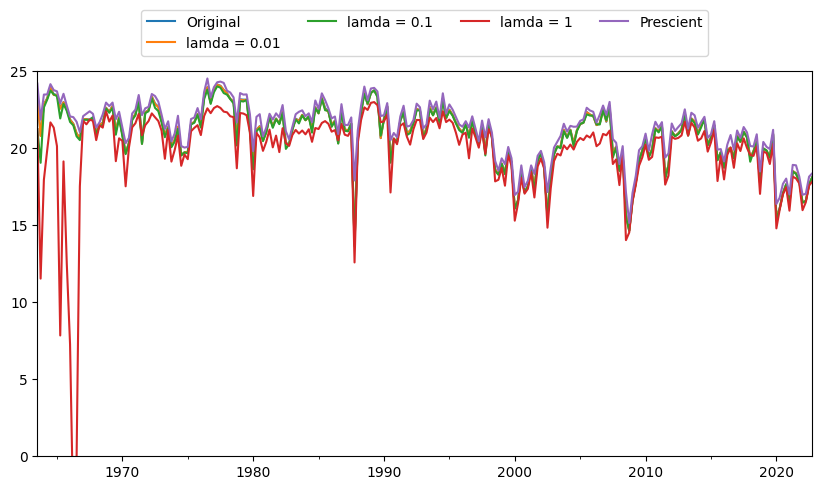

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'PRESCIENT':
        log_likelihoods[name].resample("Q").mean().plot(label=name, c="k")
    else:
        log_likelihoods[name].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=names, scatterpoints=1, markerscale=5);
plt.ylim(0,25);

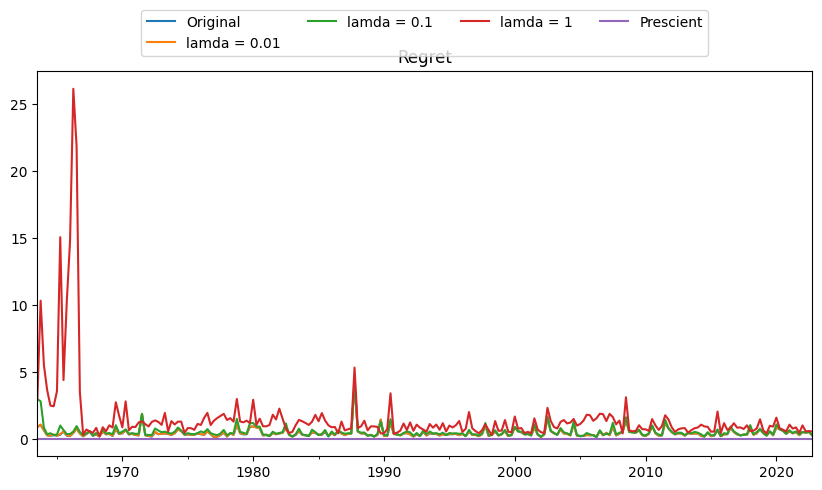

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'PRESCIENT':
        pass
    else:
        regrets[name].resample("Q").mean().plot(label=name)
plt.title("Regret")
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=names, scatterpoints=1, markerscale=5);
# plt.ylim(-0.5,10);


In [103]:
regrets["Original"].resample("Q").mean()

1963-09-30    0.895445
1963-12-31    1.038051
1964-03-31    0.629339
1964-06-30    0.251328
1964-09-30    0.222454
                ...   
2021-12-31    0.266307
2022-03-31    0.502587
2022-06-30    0.463146
2022-09-30    0.504135
2022-12-31    0.244182
Freq: Q-DEC, Length: 238, dtype: float64

In [105]:
regrets["lamda = 0.01"].resample("Q").mean()

1963-09-30    0.873856
1963-12-31    1.067579
1964-03-31    0.652256
1964-06-30    0.267943
1964-09-30    0.234182
                ...   
2021-12-31    0.269265
2022-03-31    0.502135
2022-06-30    0.463433
2022-09-30    0.504719
2022-12-31    0.244973
Freq: Q-DEC, Length: 238, dtype: float64